In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import warnings
import numpy as np
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb

sys.path.append("../examples/")
from loading import *

In [74]:
lam = "heat"

grid = load_baltic("natv", "hourly")
default_bins=True

budgets_dict = xbudget.load_preset_budget(model="MOM6_3Donly")
xbudget.collect_budgets(grid._ds, budgets_dict)
simple_budget = xbudget.aggregate(budgets_dict)

# Note: the properties of this region are quite different from the rest of the Baltic!
name = "intBaltic"
lons = np.array([8.,   20.,  29., 24.5, 24.5, 26.1, 17.5, 11.5])
lats = np.array([53.5, 53.5, 54.5,  59.,  61.,  63., 64.5,  62.])
region = regionate.GriddedRegion(name, lons, lats, grid)

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    wmb = xwmb.WaterMassBudget(
        grid,
        budgets_dict,
        region
    )
    wmb.mass_budget(lam, default_bins=default_bins)
    wmt = wmb.wmt
    wmt.load()

In [75]:
import matplotlib.pyplot as plt

thetao0 = 1.

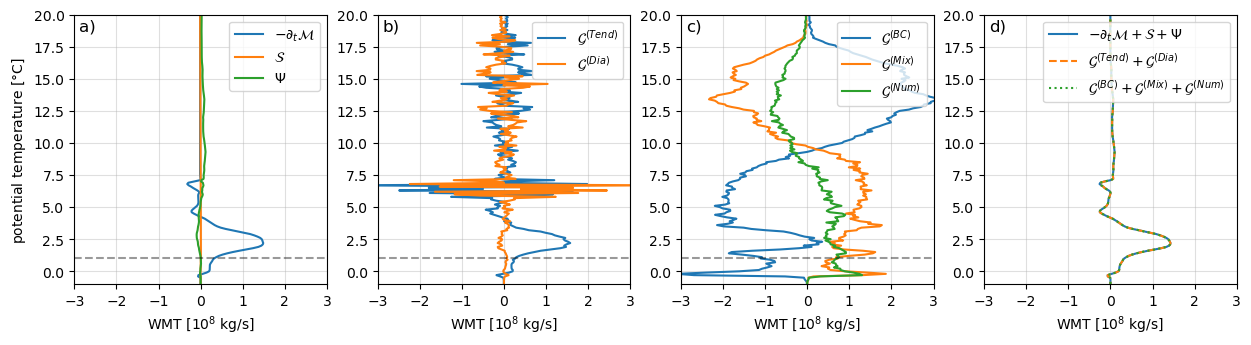

In [93]:
plt.figure(figsize=(15,3.5))

plt.subplot(1,4,1)
(-wmt['mass_tendency']*1e-8).mean('time').plot(y="thetao_l_target", label=r"$-\partial_{t} \mathcal{M}$", color="C0")
(wmt['mass_source']*1e-8).mean('time').plot(y="thetao_l_target", label=r"$\mathcal{S}$", color="C1")
(wmt['overturning']*1e-8).mean('time').plot(y="thetao_l_target", label=r"$\Psi$", color="C2")
plt.legend()
plt.grid(True, alpha=0.4)
plt.ylim(-1, 20)
plt.xlim(-3, 3)
plt.xlabel(r"WMT [$10^{8}$ kg/s]");
plt.ylabel(r"potential temperature [$\degree$C]")
plt.title("a)", loc="left", y=0.91, x=0.02)
plt.axhline(thetao0, color="k", lw=1.5, alpha=0.4, ls="--")

plt.subplot(1,4,2)
(wmt['Eulerian_tendency']*1e-8).mean('time').plot(y="thetao_l_target", label=r"$\mathcal{G}^{(Tend)}$", color="C0")
(wmt['diabatic_advection']*1e-8).mean('time').plot(y="thetao_l_target", label=r"$\mathcal{G}^{(Dia)}$", color="C1")
plt.legend(loc="upper right")
plt.grid(True, alpha=0.4)
plt.ylim(-1, 20)
plt.xlim(-3, 3)
plt.ylabel("")
plt.xlabel(r"WMT [$10^{8}$ kg/s]");
plt.title("b)", loc="left", y=0.91, x=0.02)
plt.axhline(thetao0, color="k", lw=1.5, alpha=0.4, ls="--")

plt.subplot(1,4,3)
(wmt['boundary_fluxes'].mean('time')*1e-8).plot(y="thetao_l_target", label=r"$\mathcal{G}^{(BC)}$", color="C0")
(wmt['diffusion']*1e-8).mean('time').plot(y="thetao_l_target", label=r"$\mathcal{G}^{(Mix)}$", color="C1")
(wmt['spurious_numerical_mixing']*1e-8).mean('time').plot(y="thetao_l_target", label=r"$\mathcal{G}^{(Num)}$", color="C2")
plt.legend()
plt.grid(True, alpha=0.4)
plt.ylim(-1, 20)
plt.xlim(-3, 3)
plt.ylabel("")
plt.xlabel(r"WMT [$10^{8}$ kg/s]")
plt.title("c)", loc="left", y=0.91, x=0.02)
plt.axhline(thetao0, color="k", lw=1.5, alpha=0.4, ls="--")

plt.subplot(1,4,4)
label = r"$-\partial_{t} \mathcal{M} + \mathcal{S} + \Psi$"
((-wmt['mass_tendency'] + wmt['mass_source'] + wmt['overturning'])*1e-8).mean('time').plot(y="thetao_l_target", label=label)
label = r"$\mathcal{G}^{(Tend)} + \mathcal{G}^{(Dia)}$"
((wmt['Eulerian_tendency'] + wmt['diabatic_advection'])*1e-8).mean('time').plot(y="thetao_l_target", label=label, ls="--")
label= r"$\mathcal{G}^{(BC)} + \mathcal{G}^{(Mix)} + \mathcal{G}^{(Num)}$"
((wmt['boundary_fluxes'] + wmt['diffusion'] + wmt['spurious_numerical_mixing'])*1e-8).mean('time').plot(y="thetao_l_target", label=label, ls=":")
plt.grid(True, alpha=0.4)
plt.legend(loc="upper right")
plt.ylim(-1, 20)
plt.xlim(-3, 3)
plt.ylabel("")
plt.title("d)", loc="left", y=0.91, x=0.02)
plt.xlabel(r"WMT [$10^{8}$ kg/s]");

plt.savefig("figures/three_decompositions.png", bbox_inches="tight", dpi=150)

In [78]:
lam_min, lam_max, dlam = -4.173, 40., 0.273519

grid_newbins = xwmt.add_gridcoords(grid, {}, {})
grid_newbins._ds = grid_newbins._ds.assign_coords({
    f"thetao_l_target" : np.arange(lam_min, lam_max, dlam),
    f"thetao_i_target" : np.arange(lam_min-dlam/2., lam_max+dlam/2, dlam),
})
grid_newbins = xwmt.add_gridcoords(
    grid_newbins,
    {"Z_target": {"center": "thetao_l_target", "outer": "thetao_i_target"}},
    {"Z_target": "extend"}
)

wmb_newbins = xwmb.WaterMassBudget(
    grid_newbins,
    budgets_dict,
    region
)
wmb_newbins.mass_budget("heat")
wmt_newbins = wmb_newbins.wmt
wmt_newbins.load();

/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/transform.py:245: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/transform.py:245: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/transform.py:245: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/transform.py:245: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct paramet

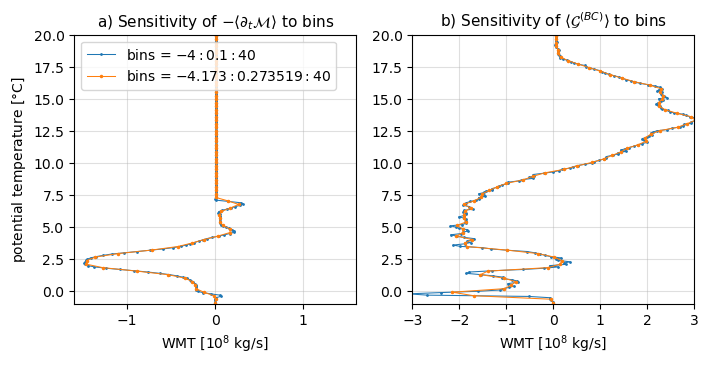

In [89]:
plt.figure(figsize=(8,3.5))

plt.subplot(1,2,1)
(wmt['mass_tendency']*1e-8).mean('time').plot(y="thetao_l_target", label=r"bins = $-4:0.1:40$", marker=".", ls="-", lw=0.75, markersize=2)
(wmt_newbins['mass_tendency']*1e-8).mean('time').plot(y="thetao_l_target", label=r"bins = $-4.173:0.273519:40$", marker=".", ls="-", lw=0.75, markersize=3)
plt.grid(True, alpha=0.4)
plt.ylim(-1, 20)
plt.xlim(-1.6, 1.6)
plt.ylabel("")
plt.xlabel(r"WMT [$10^{8}$ kg/s]")
plt.legend(loc="upper left")
plt.ylabel(r"potential temperature [$\degree$C]")
plt.title(r"a) Sensitivity of $-\langle \partial_{t} \mathcal{M} \rangle$ to bins", fontsize=11)

plt.subplot(1,2,2)
(wmt['boundary_fluxes']*1e-8).mean('time').plot(y="thetao_l_target", label=r"bins = $-4:0.1:40$", marker=".", ls="-", lw=0.75, markersize=2)
(wmt_newbins['boundary_fluxes']*1e-8).mean('time').plot(y="thetao_l_target", label=r"bins = $-4.173:0.273519:40$", marker=".", ls="-", lw=0.75, markersize=3)
plt.grid(True, alpha=0.4)
plt.ylim(-1, 20)
plt.xlim(-3, 3)
plt.ylabel("")
plt.xlabel(r"WMT [$10^{8}$ kg/s]")
plt.title(r"b) Sensitivity of $\langle \mathcal{G}^{(BC)} \rangle$ to bins", fontsize=11);

plt.savefig("figures/lambda_bin_sensitivity.png", bbox_inches="tight", dpi=150)

In [80]:
boundary_fluxes = [
    'surface_exchange_flux',
    'surface_ocean_flux_advective_negative_lhs',
    'bottom_flux',
    'frazil_ice'
]

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    Gmix = wmb.map_transformations("heat", term="diffusion")['diffusion'].interp(thetao_l_target=thetao0).compute()
    GBC = sum([wmb.map_transformations("heat", term=term)[term] for term in boundary_fluxes]).interp(thetao_l_target=thetao0).compute()

In [81]:
Δt = wmb.grid._ds.time_bounds.diff('time_bounds').astype('float')*1.e-9
ΔmΔt = (
    (wmb.grid._ds.mass_density_bounds_less_than.diff('time_bounds') / Δt)
    .rename({"time_bounds":"time"})
    .assign_coords({'time': wmb.grid._ds.time})
    .interp(thetao_i_target=thetao0)
).compute()

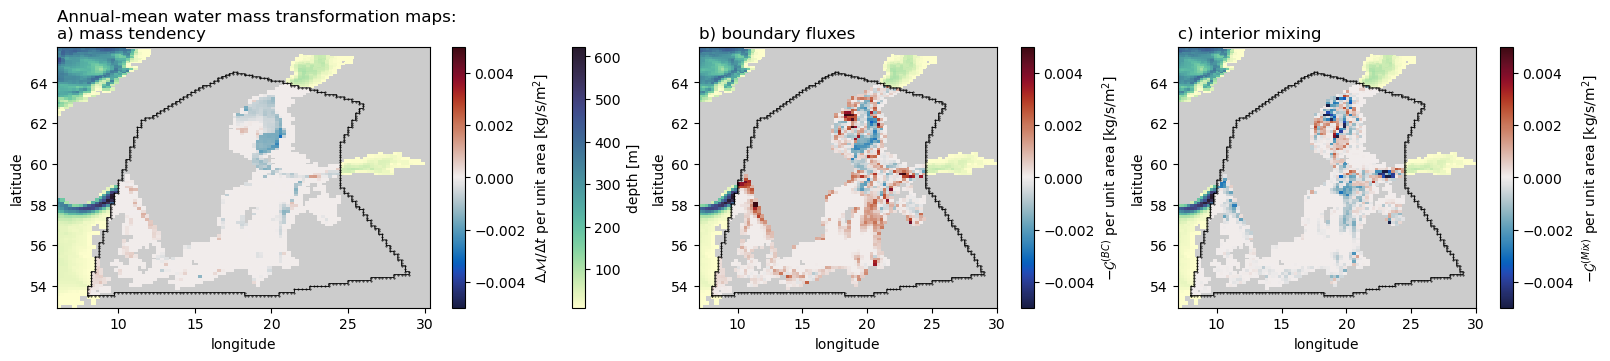

In [82]:
ds = wmb.grid._ds

import cmocean
cmap = cmocean.cm.deep.copy()
cmap.set_bad((0.8, 0.8, 0.8, 1))

div_cmap = cmocean.cm.balance.copy()
div_cmap.set_bad((0.6, 0.6, 0.6, 1))

fig = plt.figure(figsize=(16,3.5), layout="constrained")
spec = fig.add_gridspec(1, 13)

ax = fig.add_subplot(spec[0, 0:5], facecolor=cmap.get_bad())
pc = ax.pcolor(
    ds['geolon_c'],
    ds['geolat_c'],
    ds['deptho'].where(~region.mask, np.nan),
    cmap=cmap
)
plt.colorbar(pc, label="depth [m]")
pc = ax.pcolor(
    ds['geolon_c'],
    ds['geolat_c'],
    ΔmΔt.where(region.mask & (~np.isnan(ds['deptho'])), np.nan).mean('time'),
    vmin=-0.005, vmax=0.005, cmap=div_cmap
)
plt.colorbar(pc, label="$\Delta \mathcal{M}/\Delta t$ per unit area [kg/s/m$^{2}$]")
plt.plot(regionate.loop(region.lons), regionate.loop(region.lats), color="k", linewidth=0.6, markersize=0.8, marker=".")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("Annual-mean water mass transformation maps:\na) mass tendency", loc="left")

ax = fig.add_subplot(spec[0, 5:9], facecolor=cmap.get_bad())
pc = ax.pcolor(
    ds['geolon_c'],
    ds['geolat_c'],
    (-GBC).where(region.mask & (~np.isnan(ds['deptho'])), np.nan).mean('time'),
    vmin=-0.005, vmax=0.005, cmap=div_cmap
)
ax.pcolor(
    ds['geolon_c'],
    ds['geolat_c'],
    ds['deptho'].where(~region.mask, np.nan),
    cmap=cmap
)
plt.colorbar(pc, label=r"$-\mathcal{G}^{(BC)}$ per unit area [kg/s/m$^{2}$]")
plt.plot(regionate.loop(region.lons), regionate.loop(region.lats), color="k", linewidth=0.6, markersize=0.8, marker=".")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("b) boundary fluxes", loc="left")
plt.xlim(7,30)

ax = fig.add_subplot(spec[0, 9:], facecolor=cmap.get_bad())
pc = ax.pcolor(
    ds['geolon_c'],
    ds['geolat_c'],
    (-Gmix).where(region.mask & (~np.isnan(ds['deptho'])), np.nan).mean('time'),
    vmin=-0.005, vmax=0.005, cmap=div_cmap
)
ax.pcolor(
    ds['geolon_c'],
    ds['geolat_c'],
    ds['deptho'].where(~region.mask, np.nan),
    cmap=cmap
)
plt.colorbar(pc, label=r"$-\mathcal{G}^{(Mix)}$ per unit area [kg/s/m$^{2}$]")
plt.plot(regionate.loop(region.lons), regionate.loop(region.lats), color="k", linewidth=0.6, markersize=0.8, marker=".")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("c) interior mixing", loc="left")
plt.xlim(7,30)

#plt.tight_layout()
plt.savefig("figures/transformation_maps.png", bbox_inches="tight", dpi=150)

In [83]:
trans = (ds.convergent_mass_transport_less_than.interp(thetao_i_target=thetao0).mean('time')).compute()
trans_mask = (ds.convergent_mass_transport_less_than.isel(thetao_i_target=-1).mean('time')).compute()

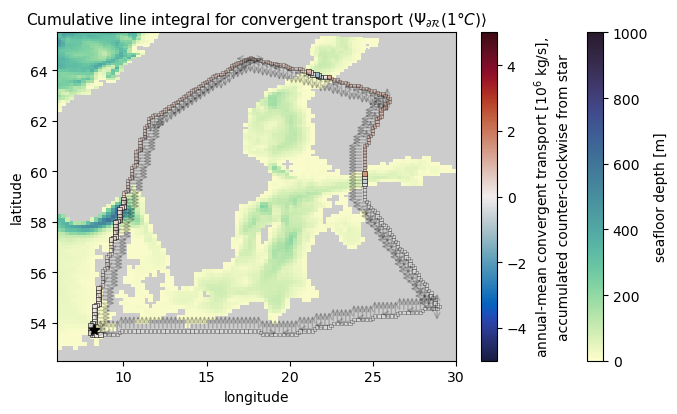

In [84]:
import cmocean

deep_cmap = cmocean.cm.deep.copy()
deep_cmap.set_bad((0.8, 0.8, 0.8))

plt.figure(figsize=(7, 4.25))
plt.subplot(facecolor=deep_cmap.get_bad())
plt.pcolor(
    ds['geolon_c'],
    ds['geolat_c'],
    ds['deptho'].where(ds.deptho!=0.),
    cmap=deep_cmap,
    vmin = 0,
    vmax = 1000
)
plt.colorbar(label="seafloor depth [m]")
for p in trans:
    plt.annotate(
        text="",
        xy=(p.lon_sect.values +p.sign.values*(p.dir.values=="U")*1.75*0.65, p.lat_sect.values +p.sign.values*(p.dir.values=="V")*1.75*0.4),
        xytext=(p.lon_sect.values, p.lat_sect.values),
        arrowprops=dict(arrowstyle="->", facecolor='black', alpha=0.2)
    )

sc = plt.scatter(
    trans['lon_sect'],
    trans['lat_sect'],
    c = ((trans.cumsum("sect")
         .where(trans_mask==0.)))*1e-6,
    marker="s",
    s = 6,
    cmap=cmocean.cm.balance,
    vmin = -5,
    vmax = 5,
    edgecolor="k",
    linewidth=0.5,
    alpha=0.4
)
sc = plt.scatter(
    trans['lon_sect'],
    trans['lat_sect'],
    c = ((trans.cumsum("sect")
         .where(trans_mask!=0.)))*1e-6,
    marker="s",
    s = 12,
    cmap=cmocean.cm.balance,
    vmin = -5,
    vmax = 5,
    edgecolor="k",
    linewidth=0.4,
)
plt.plot(
    trans['lon_sect'][0]+0.1,
    trans['lat_sect'][0]+0.2,
    "k*",
    markersize=8
)
plt.colorbar(sc, label="annual-mean convergent transport [$10^{6}$ kg/s],\n"+r"accumulated counter-clockwise from star")
plt.xlim(6,30)
plt.ylim(52.5, 65.5)
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title(r"Cumulative line integral for convergent transport $\langle \Psi_{\partial \mathcal{R}} (1 \degree C) \rangle$", fontsize=11);
plt.tight_layout();
plt.savefig("figures/convergent_mass_transport.png", bbox_inches="tight", dpi=150)